# Analiza svjetskih trendova očekivanog životnog vijeka i faktora koji na njih utječu

## Uvod
U ovom eseju proučavamo, koristeći WHO-ove javno dostupne izvore podataka, kako se procjena očekivanog životnog vijeka mijenjala u raznim državama svijeta tijekom nedavne povijesti te pokušavamo identificirati razne paralelne faktore (poput trenda rasta BMI-ja, utjecaja nekih bolesti itd.) koji po mogućnosti sputavaju značajnije povećanje svjetskog prosjeka očekivanog životnog vijeka.
Također ćemo se posebno osvrnuti na lokalni trend u Hrvatskoj i pokušati ga korelirati s nekim drugim trendovima za koje postoje pouzdani podaci.

### O WHO-ovom repozitoriju podataka
Svjetska zdravstvena organizacija (WHO) održava **Global Health Observatory** (GHO) portal koji daje pristup raznim statistikama vezanim za zdravlje 194 zemalja članica WHO-a. Pritom je moguć uvid u preko tisuću indikatora za koje se smatraju da najviše utječu na zdravlje diljem svijeta te da se mogu razumno koristiti u komparativne svrhe s povijesnim podacima. Ti indikatori uključuju utjecaj zaraznih bolesti, kvalitetu zdravstvenih sustava, čistoću okoliša i zraka, udio nasilnih zločina itd.

# Analiza globalnih trendova zdravlja

Prvo implementiramo neke pomoćne funkcije.

In [591]:
import math
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import glob
from urllib.request import urlopen, Request
from functools import partial

%matplotlib notebook

def cacheirane_datoteke(ext):
    return {os.path.basename(abspath) for abspath in glob.glob("./*." + ext)}


def skini_i_cacheiraj(url: str, ext="xml"):
    datoteka = url.split('/')[-1].split('?')[0] + '.' + ext
    if datoteka not in cacheirane_datoteke(ext):
        zahtjev = Request(url, headers={'User-Agent': 'Mozilla/5.0'}) # moramo se pretvarati da smo browser kako bi nam WHO dopustio pristup
        with urlopen(zahtjev) as konekcija:
            pathlib.Path(datoteka).write_bytes(konekcija.read())
        
    return datoteka
    
def nacrtaj(df: pd.DataFrame, y_naslov=None, vrijednosti="Numeric", tip="line", ax=None, ylim=None):
    if df.index.name != "Godina":
        min_godina = df["Godina"].min()
        max_godina = df["Godina"].max()
        df.set_index("Godina", inplace=True)
    else:
        # očisti smeće u stupcu Godina

        #df.replace(to_replace=r'^No data.*$', value=np.nan, regex=True, inplace=True)
        #df = df.loc[df.index.dropna()]
        #df.set_index("Godina", inplace=True)
        #df.dropna(inplace=True)
        #df.reset_index(inplace=True)
        #df = df.loc[df.index.dropna()]
        #df.drop(df.index[~df[df.index.notnull]], axis=1, inplace=True)
        #print(df)
        min_godina = int(df.index.min())
        max_godina = int(df.index.max())
        
    if ax is not None:
        ax.clear()

    if vrijednosti in df.columns:
        if tip == "line":
            df[vrijednosti].sort_index().drop_duplicates().plot(kind=tip, ax=ax, xlabel="Godina", ylabel=y_naslov,
                                                                xticks=range(min_godina, max_godina+1, 4)
                                                               )
        else:
            df[vrijednosti].sort_index().drop_duplicates().plot(kind=tip, ax=ax)
    else:
        if tip == "line":
            df.sort_index().drop_duplicates().plot(kind=tip, ax=ax, xlabel="Godina", ylabel=y_naslov,
                                                   xticks=range(min_godina, max_godina+1, 4)
                                                  )
        else:
            df.sort_index().drop_duplicates().plot(kind=tip, ax=ax)
            
    ax.set_ylim([None,ylim])
    plt.show()
        
    
def filtriraj(df: pd.DataFrame, filtri: dict, makni_osim=None):
    tmp = df
    for filtar, vrijednost in filtri.items():
        if tmp is df:
            if type(vrijednost) is pd.Series or type(vrijednost) is pd.Index:
                tmp = df[filtar].isin(vrijednost)
            elif type(vrijednost) is not tuple or vrijednost[0] == vrijednost[1]:
                tmp = (df[filtar] == vrijednost)
            elif type(vrijednost) is tuple:
                tmp = (df[filtar] >= vrijednost[0]) & (df[filtar] < vrijednost[1])
        else:
            if type(vrijednost) is pd.Series:
                tmp &= df[filtar].isin(vrijednost)
            elif type(vrijednost) is not tuple or vrijednost[0] == vrijednost[1]:
                tmp &= (df[filtar] == vrijednost)
            else:
                tmp &= (df[filtar] >= vrijednost[0]) & (df[filtar] < vrijednost[1])
    
    
    df2 = df.loc[tmp]
    #for filtar in filtri.keys():
     #   del df2[filtar]
        
    if makni_osim is not None:
        for stupac in df2.columns:
            if stupac not in makni_osim:
                del df2[stupac]
        
    return df2
    
def nacrtaj_kombinirani_indikator_kroz_godine(df: pd.DataFrame, filtri: dict, indikator: str, indikator_hr: str,
                                              kombinirati_po: str, za_obrisati=None, indikator_ključ="GHO",
                                              vrijednosti="Numeric", tip="line", ax=None, ylim=None):
    kombinirano = df.copy()
    if za_obrisati is not None: 
        for ključ, vrijednost in za_obrisati.items():
            kombinirano.drop(df[df[ključ] == vrijednost].index, inplace=True)
    
    filtri[indikator_ključ] = indikator
    kombinirano = filtriraj(kombinirano, filtri)
    #if "Godina" not in kombinirano.index:
    kombinirano.set_index(["Godina", kombinirati_po], drop=False, inplace=True)
    #else:
    #kombinirano.set_index(kombinirati_po, append=True, inplace=True)
    kombinirano = kombinirano.loc[~kombinirano.index.duplicated(), vrijednosti].unstack(kombinirati_po)
    nacrtaj(kombinirano, y_naslov=indikator_hr, tip=tip, ax=ax, ylim=ylim)
    
def nacrtaj_indikator_kroz_godine(df: pd.DataFrame, filtri: dict, indikator: str, indikator_hr: str,
                                  indikator_ključ="GHO", tip="line", ax=None, ylim=None):
    df2 = filtriraj(df, filtri)
    nacrtaj(df2, y_naslov=indikator_hr, tip=tip, ax=ax, ylim=ylim)
    
def prevedi_na_hrvatski(df: pd.DataFrame):
    """ Prevodi nazive pojedinih bitnih stupaca na hrvatski, radi prikazivanja na grafovima i widgetima. """
    df.rename(columns={"SEX": "Spol", "YEAR": "Godina"}, inplace=True) 
    df.replace(to_replace={"Male": "Muški", "Female": "Ženski", "Both sexes": "Oba spola",
                           "BTSX": "Oba spola", "MLE": "Muški", "FMLE": "Ženski"}, inplace=True)

def handler_interakcije(change, parametar: str, reakcija: callable):
    reakcija({parametar: change["new"]})
    
def pripremi_interakciju(df: pd.DataFrame, parametri: list, filtri: dict, reakcija: callable):
    df2 = filtriraj(df, filtri)
    
    for parametar in parametri:
        if df2.dtypes[parametar] == "object":
            opcije = df2[parametar].drop_duplicates()
            
            widget = widgets.Dropdown(options=opcije, value=opcije.iloc[0], description=parametar)
        elif str(df2.dtypes[parametar]).startswith("int"):
            opcije = df2[parametar].drop_duplicates()
            widget = widgets.SelectionSlider(options=opcije, value=opcije.iloc[0], description=parametar,
                                             readout=True
                                            )
        else: # očekujemo samo neki float tip
            min_vrijednost = df2[parametar].min()
            max_vrijednost = df2[parametar].max()
            srednja_vrijednost = (min_vrijednost + max_vrijednost) / 2
            
            widget = widgets.FloatSlider(value=srednja_vrijednost, min=min_vrijednost, max=max_vrijednost,
                                         step=0.2, description=parametar, readout=True
                                        )
            
        output = widgets.Output()
        display(widget, output)
        handler = partial(handler_interakcije, parametar=parametar, reakcija=reakcija)
        widget.observe(handler, names="value")
            
            

Pogledajmo prvo kako se do prije par godina kretao očekivani životni vijek za muškarce i žene kombinirano, na globalnoj razini.

<IPython.core.display.Javascript object>


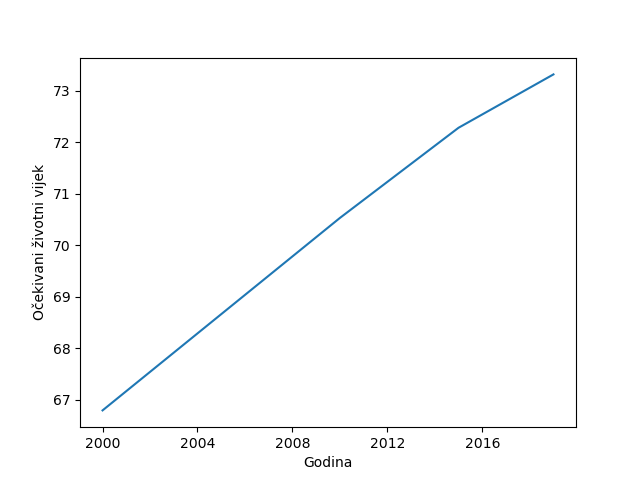

0       Eastern Mediterranean
1       Eastern Mediterranean
2       Eastern Mediterranean
3       Eastern Mediterranean
4       Eastern Mediterranean
                ...          
2323                   Global
2324                   Global
2325                   Global
2326                   Global
2327                   Global
Name: REGION, Length: 2328, dtype: object
0           Muški
1           Muški
2           Muški
3           Muški
4          Ženski
          ...    
2323       Ženski
2324    Oba spola
2325    Oba spola
2326    Oba spola
2327    Oba spola
Name: Spol, Length: 2328, dtype: object
filtrirano:      COUNTRY                               GHO PUBLISHSTATE  REGION  \
2324    None  Life expectancy at birth (years)    Published  Global   
2325    None  Life expectancy at birth (years)    Published  Global   
2326    None  Life expectancy at birth (years)    Published  Global   
2327    None  Life expectancy at birth (years)    Published  Global   

           Spol WORLDB

In [580]:
data = skini_i_cacheiraj("https://apps.who.int/gho/athena/api/GHO/WHOSIS_000001?profile=simple")
df = pd.read_xml(data)
prevedi_na_hrvatski(df)
fig1, ax1 = plt.subplots()
nacrtaj_indikator_kroz_godine(df, {"REGION": "Global", "Spol": "Oba spola"}, "Life expectancy at birth (years)",
                              "Očekivani životni vijek", ax=ax1)


#TODO: animation widget (vidi docs) za geoviz

Dakle, populacija na globalnoj razini sve dulje živi. Pogledajmo pobliže globalne razlike između muškaraca i žena.

<IPython.core.display.Javascript object>


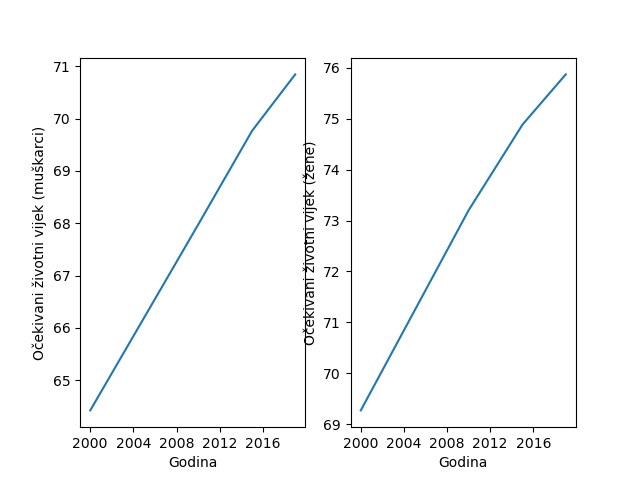

0       Eastern Mediterranean
1       Eastern Mediterranean
2       Eastern Mediterranean
3       Eastern Mediterranean
4       Eastern Mediterranean
                ...          
2323                   Global
2324                   Global
2325                   Global
2326                   Global
2327                   Global
Name: REGION, Length: 2328, dtype: object
0           Muški
1           Muški
2           Muški
3           Muški
4          Ženski
          ...    
2323       Ženski
2324    Oba spola
2325    Oba spola
2326    Oba spola
2327    Oba spola
Name: Spol, Length: 2328, dtype: object
filtrirano:      COUNTRY                               GHO PUBLISHSTATE  REGION   Spol  \
2316    None  Life expectancy at birth (years)    Published  Global  Muški   
2317    None  Life expectancy at birth (years)    Published  Global  Muški   
2318    None  Life expectancy at birth (years)    Published  Global  Muški   
2319    None  Life expectancy at birth (years)    Published  Globa

In [581]:
fig2, (axl, axr) = plt.subplots(1, 2, label="Globalna m/ž usporedba životnog vijeka")
nacrtaj_indikator_kroz_godine(df, {"REGION": "Global", "Spol": "Muški"}, "Life expectancy at birth (years)",
                              "Očekivani životni vijek (muškarci)", ax=axl)
nacrtaj_indikator_kroz_godine(df, {"REGION": "Global", "Spol": "Ženski"}, "Life expectancy at birth (years)",
                              "Očekivani životni vijek (žene)", ax=axr)

<IPython.core.display.Javascript object>


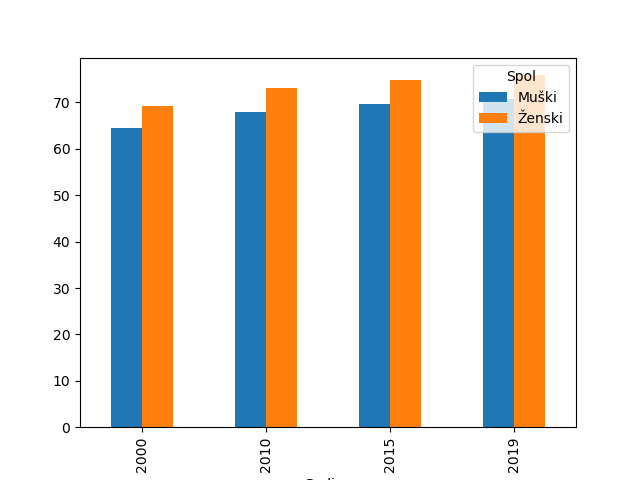

0       Eastern Mediterranean
1       Eastern Mediterranean
2       Eastern Mediterranean
3       Eastern Mediterranean
4       Eastern Mediterranean
                ...          
2319                   Global
2320                   Global
2321                   Global
2322                   Global
2323                   Global
Name: REGION, Length: 1552, dtype: object
0       Life expectancy at birth (years)
1       Life expectancy at birth (years)
2       Life expectancy at birth (years)
3       Life expectancy at birth (years)
4       Life expectancy at birth (years)
                      ...               
2319    Life expectancy at birth (years)
2320    Life expectancy at birth (years)
2321    Life expectancy at birth (years)
2322    Life expectancy at birth (years)
2323    Life expectancy at birth (years)
Name: GHO, Length: 1552, dtype: object
filtrirano:      COUNTRY                               GHO PUBLISHSTATE  REGION    Spol  \
2316    None  Life expectancy at birth (years) 

In [582]:
fig3, ax3 = plt.subplots(label="Globalna m/ž usporedba životnog vijeka")
nacrtaj_kombinirani_indikator_kroz_godine(df, {"REGION": "Global"}, "Life expectancy at birth (years)",
                                         "Očekivani životni vijek", "Spol", {"Spol": "Oba spola"},
                                          tip="bar", ax=ax3)
dftmp = filtriraj(df, {"COUNTRY": "Croatia"})

<IPython.core.display.Javascript object>


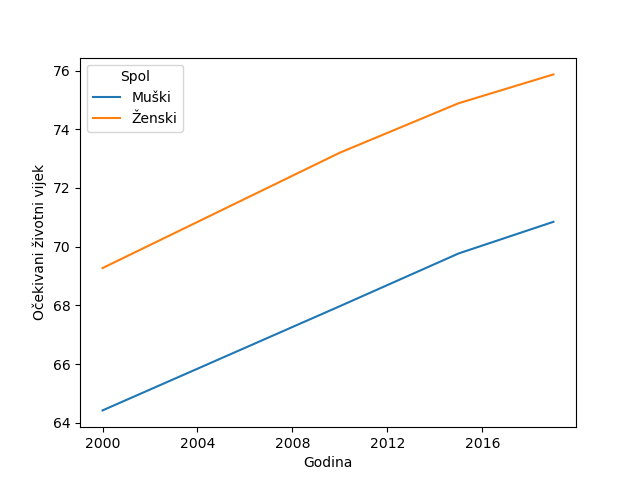

filtrirano:      COUNTRY                               GHO PUBLISHSTATE  REGION    Spol  \
2316    None  Life expectancy at birth (years)    Published  Global   Muški   
2317    None  Life expectancy at birth (years)    Published  Global   Muški   
2318    None  Life expectancy at birth (years)    Published  Global   Muški   
2319    None  Life expectancy at birth (years)    Published  Global   Muški   
2320    None  Life expectancy at birth (years)    Published  Global  Ženski   
2321    None  Life expectancy at birth (years)    Published  Global  Ženski   
2322    None  Life expectancy at birth (years)    Published  Global  Ženski   
2323    None  Life expectancy at birth (years)    Published  Global  Ženski   

     WORLDBANKINCOMEGROUP  Godina  Display   Numeric  
2316               Global    2000     64.4  64.41902  
2317               Global    2010     68.0  67.97157  
2318               Global    2015     69.8  69.76766  
2319               Global    2019     70.8  70.84768  
2

In [574]:
fig4, ax4 = plt.subplots()
nacrtaj_kombinirani_indikator_kroz_godine(df, {"REGION": "Global"}, "Life expectancy at birth (years)",
                                         "Očekivani životni vijek", "Spol", {"Spol": "Oba spola"}, ax=ax4)

<IPython.core.display.Javascript object>


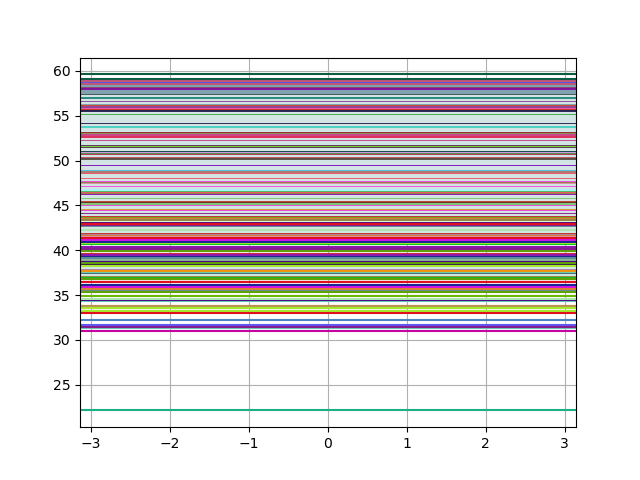

<IPython.core.display.Javascript object>


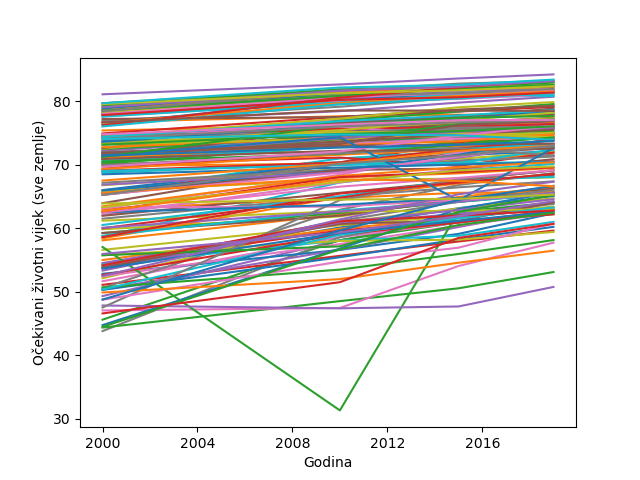

Index je godina: (2000, 2019)


In [558]:
from pandas.plotting import andrews_curves
#df_trend_vijek1 = filtriraj(df, {"Spol": "Oba spola", "Godina": 2019}, ["Display", "COUNTRY"])
df_trend_vijek1 = filtriraj(df, {"Spol": "Oba spola"}, ["Display", "COUNTRY"])
fig5, ax5 = plt.subplots()
andrews_curves(df_trend_vijek1, "COUNTRY")
ax5.get_legend().remove()

fig6, ax6 = plt.subplots()
#df_trend_vijek2 = filtriraj
nacrtaj_kombinirani_indikator_kroz_godine(df, {"Spol": "Oba spola"}, "Life expectancy at birth (years)",
                                         "Očekivani životni vijek (sve zemlje)", "COUNTRY", ax=ax6)
ax6.get_legend().remove()

Uočavamo iz gornjeg grafa da neke države doživljavaju ili su u prošlosti doživjele značajne padove očekivanog vijeka. Pogledajmo koje su to države.

In [561]:
def pronađi_pad(df: pd.DataFrame):
    df = filtriraj(df, {"Spol": "Oba spola"})
    niz = df.sort_values(by="Godina")["Display"]
    if niz.size == 0:
        return math.inf, 0
    
    min_delta = math.inf
    početak_pada = 0
    kraj_pada = -1
    najgora_godina = None
    u_padu = False
    
    for i in range(len(niz)):
        if i == 0:
            continue
        if niz.iloc[i] < niz.iloc[i - 1]:
            if not u_padu:
                u_padu = True
                početak_pada = i - 1
        elif niz.iloc[i] > niz.iloc[i - 1]:
            if u_padu:
                u_padu = False
                kraj_pada = i - 1
                if min_delta > niz.iloc[kraj_pada] - niz.iloc[početak_pada]:
                    min_delta = niz.iloc[kraj_pada] - niz.iloc[početak_pada]
                    najgora_godina = niz.iloc[i - 1]
                    
                #min_delta = min(min_delta, niz.iloc[kraj_pada] - niz.iloc[početak_pada])
                početak_pada = kraj_pada
            
    if min_delta > niz.iloc[kraj_pada] - niz.iloc[početak_pada]:
        min_delta = niz.iloc[kraj_pada] - niz.iloc[početak_pada]
        najgora_godina = niz.iloc[i - 1]
        #min_delta = min(min_delta, niz.iloc[-1] - niz.iloc[početak_pada])
    return (min_delta, najgora_godina)

<IPython.core.display.Javascript object>


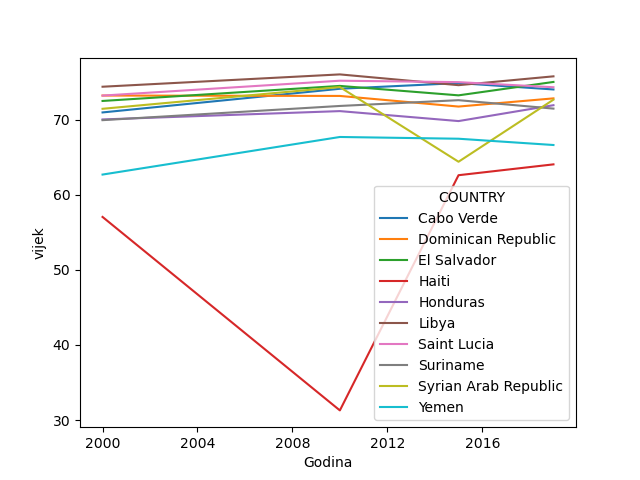

Index je godina: (2000, 2019)


In [560]:
zemlje = df["COUNTRY"].drop_duplicates()
najgore = {zemlja: pronađi_pad(df[df["COUNTRY"] == zemlja]) for zemlja in zemlje}
df_zemlje = pd.Series({zemlja: vrijednost[0] for zemlja, vrijednost in najgore.items()})
#df_zemlje
najgori_padovi = df_zemlje.sort_values().head(10)
najgore_države = najgori_padovi.index
fig10, ax10 = plt.subplots()
nacrtaj_kombinirani_indikator_kroz_godine(df, {"COUNTRY": najgore_države, "Spol": "Oba spola"},
                                          "Life expectancy at birth (years)", "vijek", "COUNTRY", ax=ax10
                                         )


Većina država koje su prošle značajan pad životnog vijeka su na afričkom kontinentu ili u srednjem dijelu američkog kontinenta. Ovdje su iznimka Sirija i Jemen, koji su doživjeli mnoge krize ili ratove u posljednjih desetak godina i stoga je došlo do većih imigracija ili smrti. Gornji graf ne obuhvaća potencijalno velike razarajuće efekte COVID-19 pandemije u tim državama, koji su najvjerojatnije doprinijeli još većem padu nakon 2020. godine (službeni podaci još ne postoje).

Iz doljnje analize vidimo da zelena crta s najmanjom vrijednošću odgovara Haitiju, koji ima apsolutno najgori očekivani životni vijek. Kako bismo objasnili tako loše rezultate, pogledajmo Haiti u izolaciji.

<IPython.core.display.Javascript object>


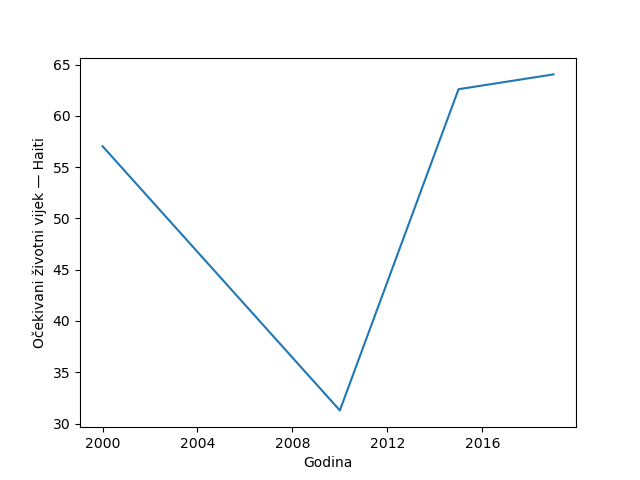

In [562]:
fig9, ax9 = plt.subplots()
nacrtaj_indikator_kroz_godine(df, {"Spol": "Oba spola", "COUNTRY": "Haiti"}, "Life expectancy at birth (years)",
                             "Očekivani životni vijek — Haiti", ax=ax9)

In [563]:
filtriraj(df, {"Spol": "Oba spola", "COUNTRY": "Haiti"}, ["Godina", "Display"]).set_index("Godina")

,Display
Godina,
2000,57.0
2010,31.3
2015,62.6
2019,64.1


Po gornjoj listi vidimo da Haiti nije davao dovoljno podataka o populaciji između 2000. i 2010., kada se dogodio razorni potres, pa dobivamo pomalo iskrivljenu sliku naglog pada životnog vijeka. Ipak, vidimo da se do 2015. stanje uspjelo vratiti, pa donekle i prestići ono pretpotresno.

865                        Haiti
120                      Burundi
324     Central African Republic
2172                      Zambia
312                     Botswana
                  ...           
348                  Switzerland
84                     Australia
1848                      Sweden
1008                       Japan
948                      Iceland
Name: COUNTRY, Length: 184, dtype: object


<IPython.core.display.Javascript object>


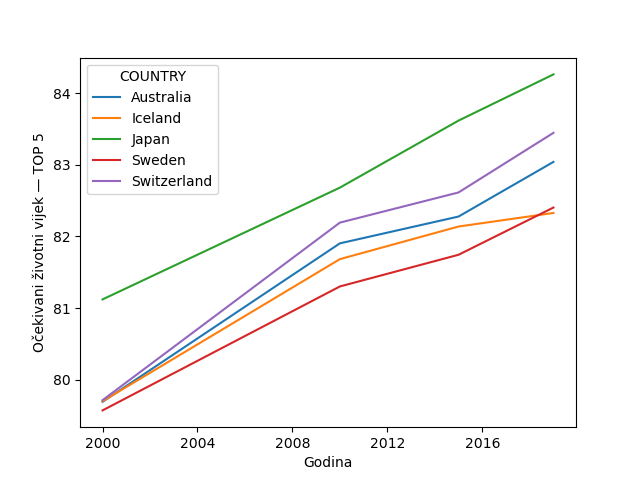

Index je godina: (2000, 2019)


interactive(children=(IntSlider(value=5, description='Najboljih', max=10, min=1), Output()), _dom_classes=('wi…

<function __main__.<lambda>(Najboljih)>

In [564]:
df_po_vijeku = df.sort_values(by="Display").drop_duplicates("COUNTRY")["COUNTRY"]
print(df_po_vijeku)
fig7, ax7 = plt.subplots()
nacrtaj_kombinirani_indikator_kroz_godine(df, {"Spol": "Oba spola", "COUNTRY": df_po_vijeku.tail(5)},
                                          "Life expectancy at birth (years)",
                        
                                          "Očekivani životni vijek — TOP 5", "COUNTRY", ax=ax7
                                         )
def ažuriraj_graf_tail(tail: int):
    nacrtaj_kombinirani_indikator_kroz_godine(df, ax=ax7,
                                              filtri={"Spol": "Oba spola", "COUNTRY": df_po_vijeku.tail(tail)},
                                              indikator="Life expectancy at birth (years)",
                                             indikator_hr="Očekivani životni vijek — TOP " + str(tail),
                                             kombinirati_po="COUNTRY"
                                             )

from ipywidgets import interact
interact(lambda Najboljih: ažuriraj_graf_tail(Najboljih), Najboljih=(1, 10))

Države koje su najjače u smislu očekivanog životnog vijeka, pa onda i prosječnog zdravlja stanovništva, su raspršene po kontinentima, pa tako nalazimo "top 5" u Japanu, Švicarskoj, Australiji, Icelandu i Švedskoj.

<IPython.core.display.Javascript object>


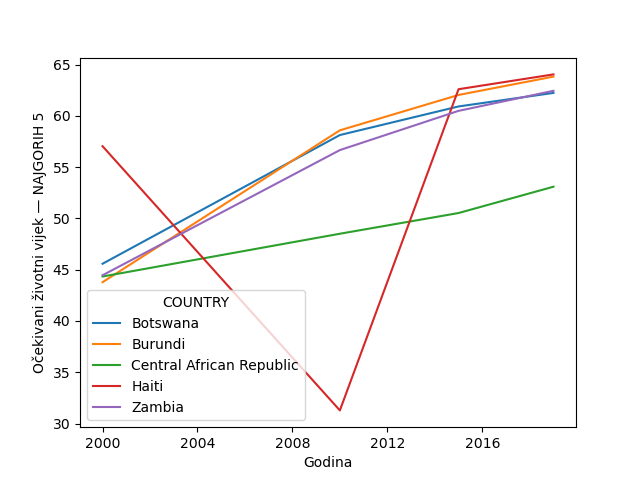

Index je godina: (2000, 2019)


interactive(children=(IntSlider(value=5, description='Najgorih', max=10, min=1), Output()), _dom_classes=('wid…

<function __main__.<lambda>(Najgorih=(1, 10))>

In [565]:
fig80, ax80= plt.subplots()
nacrtaj_kombinirani_indikator_kroz_godine(df, {"Spol": "Oba spola", "COUNTRY": df_po_vijeku.head(5)},
                                          "Life expectancy at birth (years)",
                                         "Očekivani životni vijek — NAJGORIH 5", "COUNTRY", ax=ax80
                                         )
def ažuriraj_graf_head(head: int):
    nacrtaj_kombinirani_indikator_kroz_godine(df, ax=ax80,
                                              filtri={"Spol": "Oba spola", "COUNTRY": df_po_vijeku.head(head)},
                                              indikator="Life expectancy at birth (years)",
                                             indikator_hr="Očekivani životni vijek — NAJGORIH " + str(head),
                                             kombinirati_po="COUNTRY"
                                             )
    
interact(lambda Najgorih=(1, 10): ažuriraj_graf_head(Najgorih))

Najgore pak trendove u životnom vijeku opet nalazimo većinom u afričkim zemljama. Ovdje vidimo neke "anomalije" u trendu Haitija, istočno od Kube, koje možemo pripisati velikim potresima oko 2011. godine, koji su oduzeli preko 100 000 života. Nažalost, niti jedna od gornjih afričkih zemalja ni Haiti ne podržavaju globalan trend rasta životnog vijeka ni njegovog globalnog prosjeka od oko 70 godina.

## Analiza faktora koji utječu na globalne trendove zdravlja
Sada ćemo malo detaljnije pogledati gornje grafove i pokušati ustanoviti neke značajnije faktore koji su u prošlosti mogli utjecati na takve trendove u pojedinim dijelovim svijeta.

<IPython.core.display.Javascript object>


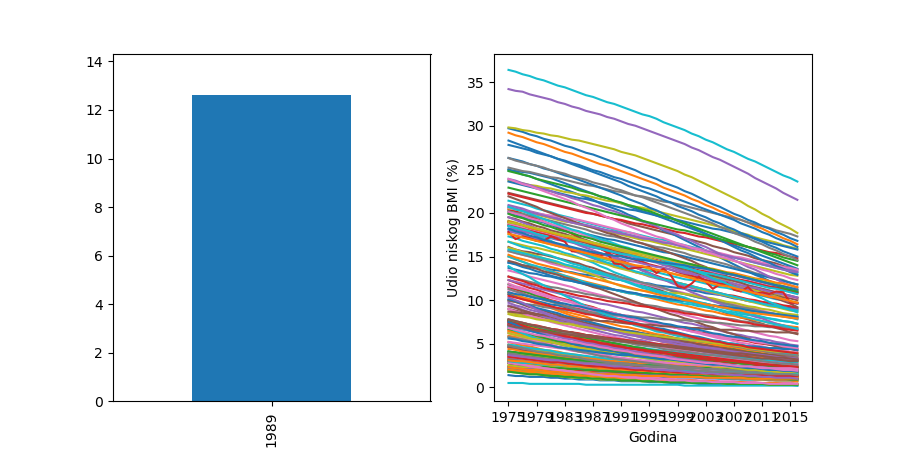

SelectionSlider(description='Godina', options=(1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 198…

Output()

In [598]:
data_bmio = skini_i_cacheiraj("https://apps.who.int/gho/athena/api/GHO/NCD_BMI_18A?profile=simple")
df_bmio = pd.read_xml(data_bmio)
df_bmio = df_bmio[(df_bmio["Numeric"].notna()) & (df_bmio["YEAR"].notna())]
prevedi_na_hrvatski(df_bmio)
#print(df_bmio["GHO"].tail())
#print(df_bmio.loc[df_bmio["REGION"]=="Global"])
fig9, (ax9, ax11) = plt.subplots(1, 2)

def interaktivni_graf(df: pd.DataFrame, kako: callable, ax, parametri, filtri: dict, indikator: str,
                      indikator_hr: str, tip="line", ylock=False, kombinirati_po=None):
    ymax = None
    if ylock:
        ymax = filtriraj(df, filtri=filtri)["Numeric"].max()
        
    kako(df, filtri, indikator=indikator, indikator_hr=indikator_hr, ax=ax, tip=tip, ylim=ymax)
    pripremi_interakciju(df, parametri, filtri,
                         lambda nove: kako(df, filtri | nove, indikator=indikator, indikator_hr=indikator_hr,
                                           ax=ax, tip=tip, ylim=ymax))
    
interaktivni_graf(df_bmio, nacrtaj_indikator_kroz_godine, ax9, ["Godina"], {"REGION": "Global", "Spol": "Oba spola"
                                                                           },
                 "Prevalence of underweight among adults, BMI < 18.5 (age-standardized estimate) (%)",
                  "Udio niskog BMI (%)", tip="bar", ylock=True)

nacrtaj_kombinirani_indikator_kroz_godine(df_bmio, {"Spol": "Oba spola"}, 
                                          "Prevalence of underweight among adults, BMI < 18.5 (age-standardized estimate) (%)"
                                          ,"Udio niskog BMI (%)",
                                          kombinirati_po="COUNTRY", ax=ax11)
ax11.get_legend().remove()

Klizanjem gornjeg *slidera* vidimo da udio pothranjenih (BMI $<18$) u globalnoj populaciji (lijevo) značajno opada svake godine — do 2020. je sišao do nešto manje od $9\%$. Desno pak vidimo da postoje značajne varijacije u tom globalnom trendu.

# Analiza lokalnih trendova zdravlja

U ovoj sekciji se fokusiramo na detaljniju analizu faktora koji utječu na zdravlje europskih zemalja tijekom vremena, i to specifično članica Europske unije. Ovdje također spada i Hrvatska, pa ćemo ostaviti posljednji dio ovog rada za detaljniju usporedbu naših trendova s onim ostalih zemalja članica te ćemo dati neke predikcije za skoriju budućnost.

TODO: za ove podatke koristiti who-euro bazu i sljedeće indikatore (uglavnom iz https://dw.euro.who.int/api/v3/data_sets/HFA a za ono što nije tamo uvije pogledaj referentnu listu na https://dw.euro.who.int/ i najvjerojatnije je pod Health-enhancing physical activity, Environment and Health ili Child and Adolescent Health):
* Life expectancy at birth
* Population aged 0-14
* Population aged 65+
* Number of live births
* Total fertility rate
* Number of all hospital discharges
* Private households' out-of-pocket payments on health as proportion of total health expenditure
* Total health expenditure as proportion of GDP
* Acute (short-stay) hospitals per 100 000
* Acute care hospital beds per 100 000
* Associate professional nurses, practising, total
* Associate professional nursing graduates, total
* Beds in publicly owned hospitals, total
* Caring personnel, practising or closest concept, total
* Computed Tomography Scanners, total
* Dentists (PP) per 100 000
* Dentists graduates, total
* Digital subtraction angiography units, total 	HRes
* Gamma cameras, total 	HRes
* General hospitals, total 	HRes
* General paediatricians, total HRes
* General practitioners (PP) per 100 000 	HFA
* Magnetic Resonance Imaging Units, total 	HRes
* Mammographs, total 	HRes
* Positron Emission Tomography scanners , total 	HRes
* Proportion of physicians, both sexes, 65 years old or older 	HRes
* Proportion of physicians, both sexes, younger than 35 years 	HRes
* Psychiatric hospital beds per 100 000 	HFA
* Psychiatrists, total 	 HRes
* Radiation therapy equipment, total 	HRes
* Abortions per 1000 live births 	HFA
* Maternal deaths, according to clinical data 	HFA
* Proportion of births attended by skilled health personnel 	HFA
* Proportion of infants breastfed at age 3 months 	HFA
* Proportion of infants vaccinated against tetanus 	HFA
* Proportion of infants vaccinated against tuberculosis 	HFA
* Proportion of live births weighing 2500 g or more 	HFA
* Microbiological foodborne diseases per 100 000 	HFA
* Number of people injured due to work-related accidents 	HFA
* Number of salmonellosis cases 	HFA
* Proportion of population with access to sewage system, septic tank or other hygienic means of sewage disposal 	HFA
* Proportion of population with homes connected to water supply system 	HFA
* Age-standardized prevalence of current tobacco smoking among people aged 15 years and over (WHO estimates) 	HFA
* Age-standardized prevalence of overweight (defined as BMI = 25 kg/m2) in people aged 18 years and over (WHO estimates) 	HFA
* Average amount of fruits and vegetables available per person per year (kg) 	HFA
* Average number of calories available per person per day (kcal) 	HFA
* Fat available per person per day (g) 	HFA
* First admissions to drug treatment centres per 100 000 	HFA
* Number cigarettes consumed per person per year 	HFA
* Number of people killed or injured in road traffic accidents 	HFA
* Number of road traffic accidents involving alcohol 	HFA
* Protein available per person per day (g) 	HFA
* Absenteeism from work due to illness, days per employee per year 	HFA
* All cases of mental disorders at year's end 	HFA
* Incidence of cancer 	HFA
* Number of all cases of diabetes mellitus at year's end 	HFA
* SDR, Accidents 	MDB
* SDR, All causes 	MDB
* SDR, Chronic lower respiratory diseases 	MDB
* SDR, diabetes, all ages 	HFA
* SDR, diseases of digestive system, all ages 	HFA
* SDR, Diseases of nervous system and sense organs 	MDB
* SDR, Diseases of the circulatory system 	MDB
* SDR, Diseases of the respiratory system 	MDB
* SDR, Diseases of the digestive system 	MDB
* SDR, endocrine, nutritional and metabolic diseases, all ages 	HFA
* SDR, homicide and intentional injury, all ages 	HFA
* SDR, infectious and parasitic diseases, all ages 	HFA
* SDR, ischaemic heart disease, all ages 	HFA
* SDR, mental disorders, diseases of nervous system and sense organs, all ages 	HFA
* SDR, motor vehicle traffic accidents, all ages 	HFA
* SDR, suicide and self-inflicted injury, all ages 	HFA
* 


## Analiza hrvatskih trendova zdravlja i usporedba s ostalim članicama EU

# Zaključak

# Bibliografija
pandas docs, stdlib docs
https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html